In [4]:
i=1

In [5]:
print(f'{i:02d}')

01


In [2]:
from fastbook import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

## Is it a bird?

<div>
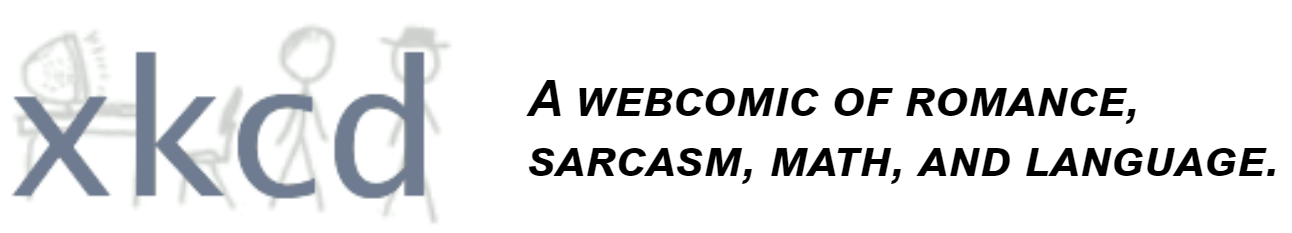
</div>
<div>
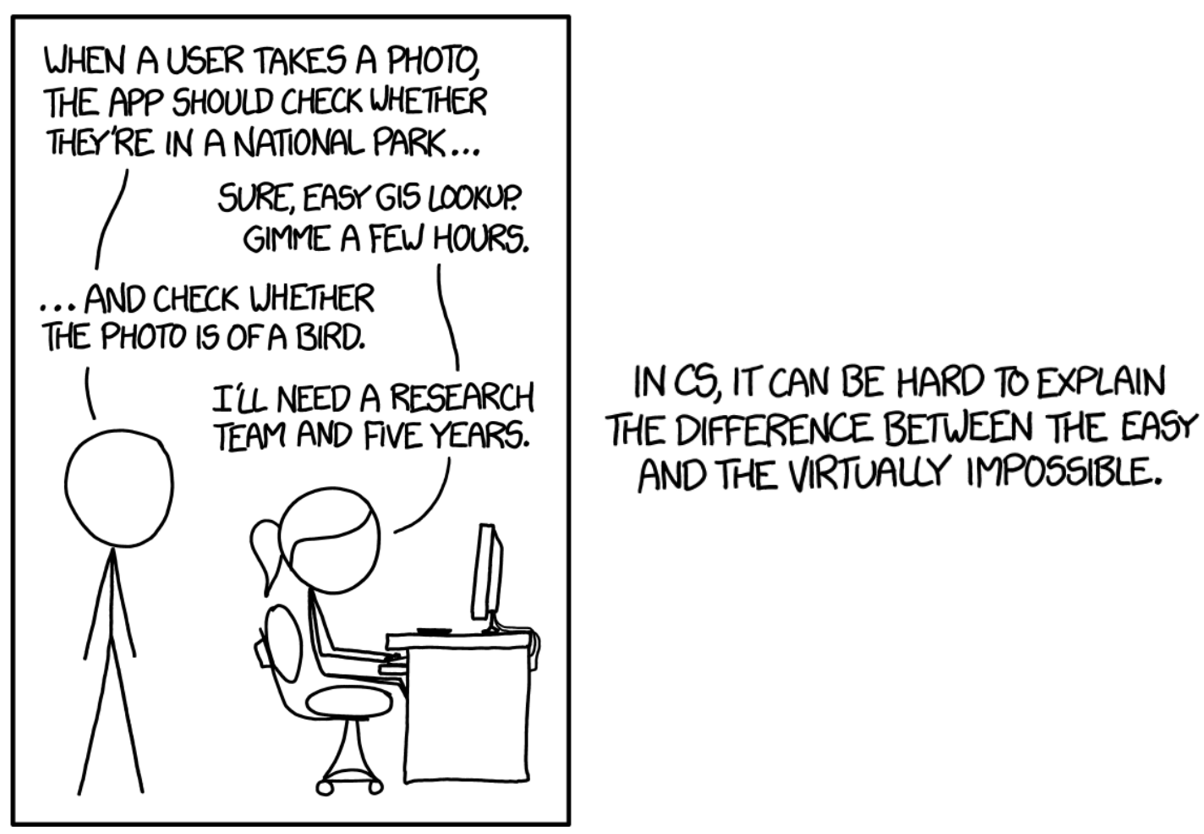
</div>
https://xkcd.com/1425/

In [3]:
urls = search_images_ddg('bird photos', max_images=1)
len(urls),urls[0]

(1,
 'https://www.superiorwallpapers.com/download/a-beautiful-red-bird-on-a-branch-bird-conservation-1600x1070.jpg')

In [4]:
dest = Path('bird.jpg')
if not dest.exists(): download_url(urls[0], dest, show_progress=False)

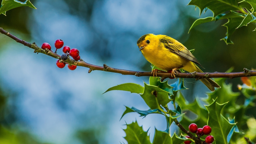

In [5]:
im = Image.open(dest)
im.to_thumb(256,256)

All models need numbers as their inputs. Images are already stored as numbers in a computer -- here's a viewer so you can see what that looks like: [PixSpy](https://pixspy.com/).

In [6]:
searches = 'forest','bird'
path = Path('bird_or_not')

if not path.exists():
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} photo')
        download_images(dest, urls=results[:200])
        resize_images(dest, max_size=400, dest=dest)

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink);

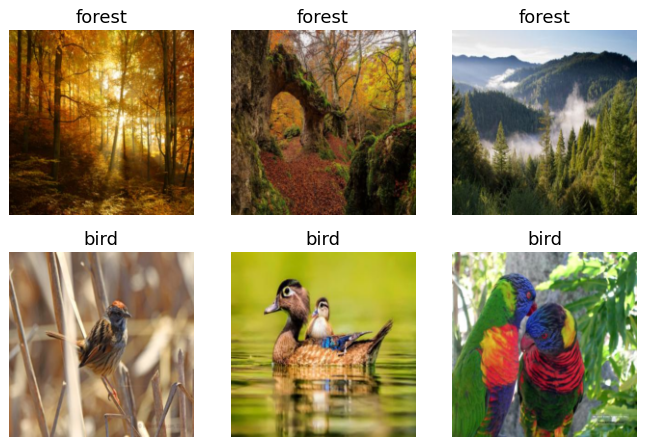

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [9]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/jhoward/git/fastai/fastai/vision/learner.py:275: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

## What happened?

A normal computer program:


In [ ]:
gv2('''program[shape=box3d width=2 height=1]
inputs->program->results''')

In [ ]:
gv2('''model[shape=box3d width=2 height=1]
inputs->model->results; weights->model''')

In [ ]:
gv2('''ordering=in
model[shape=box3d width=1.5 height=1]
inputs->model->results; weights->model; results->loss
loss->weights[constraint=false label=update]''')

In [ ]:
gv2('''model[shape=box3d width=2 height=1]
inputs->model->results''')

In [ ]:
gv2('''program[shape=box3d width=2 height=1]
inputs->program->results''')

In [ ]:
warnings.filterwarnings("ignore")

## Not just for image recognition

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

In [ ]:
learn.show_results(max_n=3, figsize=(7,8))

### Tabular analysis - income prediction

In [ ]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

In [ ]:
dls.show_batch()

In [ ]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(2)

### Collaborative filtering - recommendation system

In [ ]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')

In [ ]:
dls.show_batch()

In [ ]:
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

In [ ]:
learn.show_results()

## How do we fit a function to data?

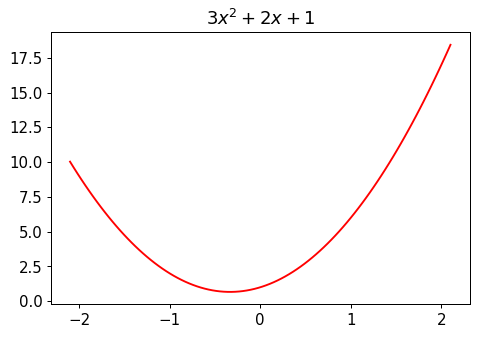

In [10]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

In [11]:
def quad(a, b, c, x): return a*x**2 + b*x + c

In [12]:
quad(3,2,1, 1.5)

10.75

In [13]:
from functools import partial
def mk_quad(a,b,c): return partial(quad, a,b,c)

In [14]:
f = mk_quad(3,2,1)
f(1.5)

10.75

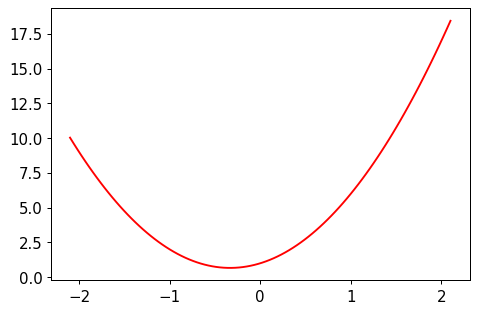

In [15]:
plot_function(f)

In [16]:
from numpy.random import normal,seed,uniform
np.random.seed(42)
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

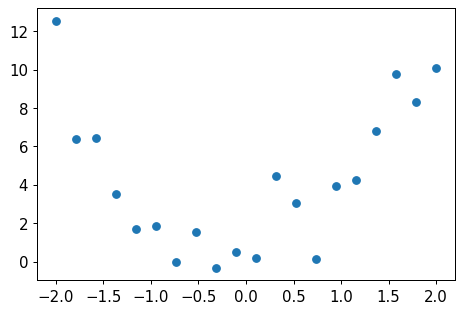

In [17]:
x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.3, 1.5)
plt.scatter(x,y);

In [18]:
from ipywidgets import interact
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c), ylim=(-3,12))

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [19]:
def mse(preds, acts): return ((preds-acts)**2).mean()

In [20]:
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mse(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MSE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [21]:
def quad_mse(params):
    f = mk_quad(*params)
    return mse(f(x), y)

In [22]:
quad_mse([1.5, 1.5, 1.5])

tensor(5.8336, dtype=torch.float64)

In [23]:
abc = torch.tensor([1.5,1.5,1.5])
abc.requires_grad_()

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

In [24]:
loss = quad_mse(abc)
loss

tensor(5.8336, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [25]:
loss.backward()

In [26]:
abc.grad

tensor([-5.1419,  2.8472, -1.1009])

In [27]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mse(abc)
    
print(f'loss={loss:.2f}')

loss=5.49


In [28]:
for i in range(5):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss:.2f}')

step=0; loss=5.49
step=1; loss=4.90
step=2; loss=4.23
step=3; loss=3.67
step=4; loss=3.33


In [29]:
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.)

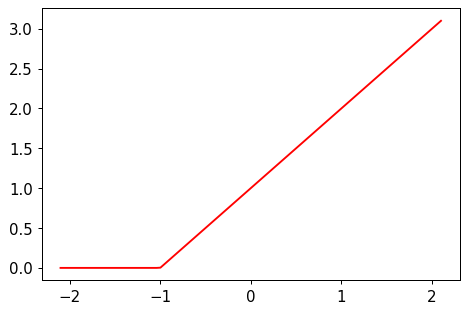

In [30]:
plot_function(partial(rectified_linear, 1,1))

In [31]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m,b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [32]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

In [33]:
@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

**How to draw an owl**
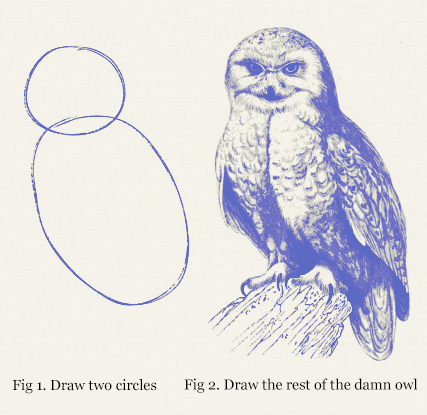

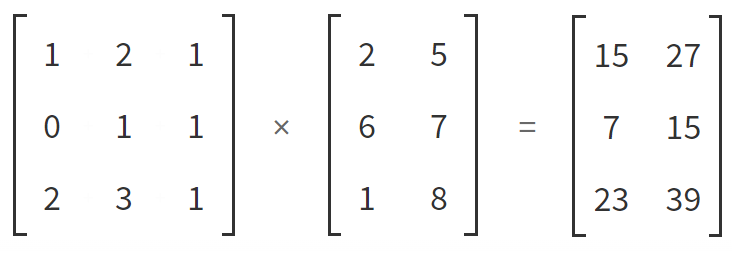
[Matrix multiplication](http://matrixmultiplication.xyz/)

## Overfitting

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

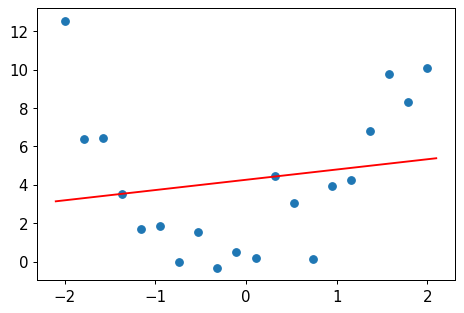

In [36]:
plot_poly(1)

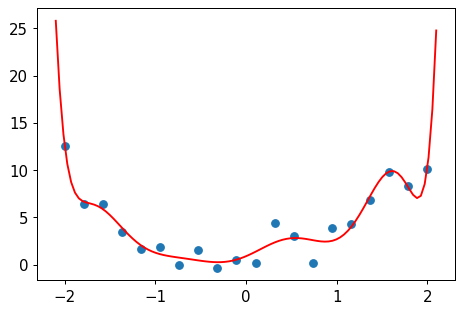

In [37]:
plot_poly(10)

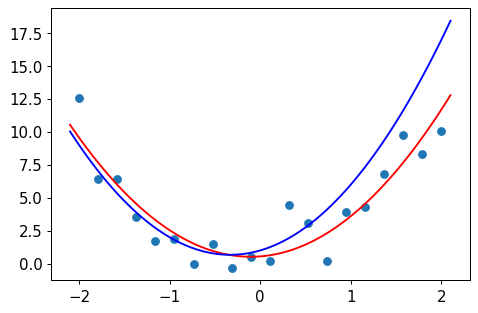

In [38]:
plot_poly(2)
plot_function(f, color='b')

### fin -